In [ ]:
import tensorflow as tf
from tensorflow import keras

# !pip install tensorflow-datasets
import tensorflow_datasets as tfds

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback;

print(f"Tensorflow version {tf.__version__}")

In [2]:
# Download project data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv -nv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv -nv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

2024-01-07 18:00:22 URL:https://cdn.freecodecamp.org/project-data/sms/train-data.tsv [358233/358233] -> "train-data.tsv" [1]
2024-01-07 18:00:22 URL:https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv [118774/118774] -> "valid-data.tsv" [1]


In [3]:
train_data = pd.read_csv(train_file_path, sep='\t', names=['y', 'x'])
test_data = pd.read_csv(test_file_path, sep='\t', names=['y', 'x'])

train_data.y.replace(['ham', 'spam'], ['0', '1'], inplace=True)
test_data.y.replace(['ham', 'spam'], ['0', '1'], inplace=True)

os.remove(train_file_path)
os.remove(test_file_path)

In [4]:
train_data.head(6)

,y,x
0,0,ahhhh...just woken up!had a bad dream about u ...
1,0,you can never do nothing
2,0,"now u sound like manky scouse boy steve,like! ..."
3,0,mum say we wan to go then go... then she can s...
4,0,never y lei... i v lazy... got wat? dat day ü ...
5,0,in xam hall boy asked girl tell me the startin...


In [5]:
train_data = train_data.astype({'y': 'int32', 'x': 'string'})
test_data = test_data.astype({'y': 'int32', 'x': 'string'})

print(f'Train dtypes:\n{train_data.dtypes}\n')
print(f'Test dtypes:\n{test_data.dtypes}')

Train dtypes:
y             int32
x    string[python]
dtype: object

Test dtypes:
y             int32
x    string[python]
dtype: object


In [6]:
max_vocab = 5000
text_length = 80

vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_vocab,
    standardize='lower_and_strip_punctuation',
    output_mode="int",
    output_sequence_length=text_length,
)

vectorization.adapt(pd.concat([train_data.x, test_data.x]))

In [7]:
vectorization("hi how are you brother")

<tf.Tensor: shape=(80,), dtype=int64, numpy=
array([100,  54,  21,   4, 618,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int64)>

In [8]:
model = tf.keras.models.Sequential()

model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorization)
 # Input dim is +1 because it's the vocabulary + the 0 token for non-vocabulary words
model.add(tf.keras.layers.Embedding(input_dim=max_vocab + 1, output_dim=32))
model.add(tf.keras.layers.LSTM(64, dropout=0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 80)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 80, 32)            160032    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 184929 (722.38 KB)
Trainable params: 184929 (722.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
EPOCHS = 30
history = model.fit(x=train_data.x, y=train_data.y, epochs=EPOCHS, shuffle=False, validation_data=(test_data.x, test_data.y), verbose=0,
    callbacks=[TqdmCallback(verbose=0)])

100%|██████████| 30/30 [01:21<00:00,  2.72s/epoch, loss=0.117, accuracy=0.981, val_loss=0.13, val_accuracy=0.971] 


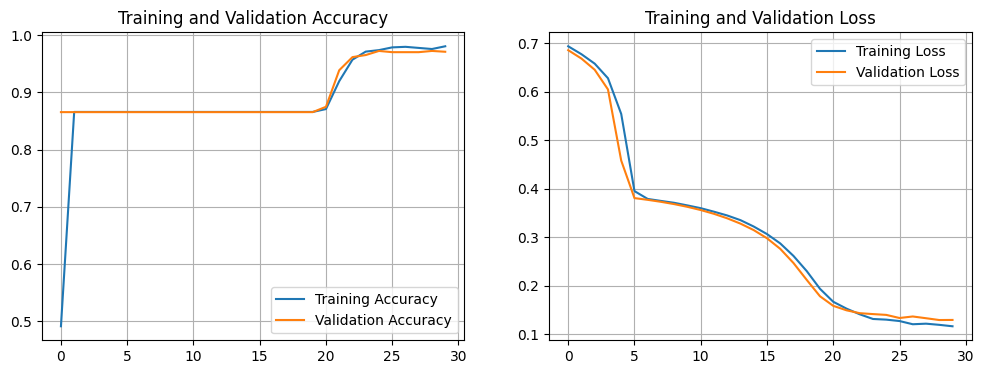

In [10]:
# Plotting the training accuracy and loss.
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.grid()
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.grid()
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [15]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  dict = {0 : 'ham',
          1 : 'spam'}
  
  # Using .item() to extract the outputs, which comes in the form of a numpy array
  x = model.predict(np.array([pred_text]), verbose=0).item() 
  
  return([x, dict[round(x)]])

pred_text = "hey buddy, how are you? this is a sample text!"

prediction = predict_message(pred_text)
print(prediction)

[0.007861358113586903, 'ham']


In [23]:
# Custom input
predict_message(str(input()))

[0.6152684092521667, 'spam']

In [16]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!
